**Challenge: Implement a Multiclass Classification Neural Network using PyTorch**

Objective:
Build a neural network using PyTorch to predict handwritten digits of MNIST.

Steps:

1. **Data Preparation**: Load the MNIST dataset using ```torchvision.datasets.MNIST```. Standardize/normalize the features. Split the dataset into training and testing sets using, for example, ```sklearn.model_selection.train_test_split()```. **Bonus scores**: *use PyTorch's built-* ```DataLoader``` *to split the dataset*.

2. **Neural Network Architecture**: Define a simple feedforward neural network using PyTorch's ```nn.Module```. Design the input layer to match the number of features in the MNIST dataset and the output layer to have as many neurons as there are classes (10). You can experiment with the number of hidden layers and neurons to optimize the performance. **Bonus scores**: *Make your architecture flexibile to have as many hidden layers as the user wants, and use hyperparameter optimization to select the best number of hidden layeres.*

3. **Loss Function and Optimizer**: Choose an appropriate loss function for multiclass classification. Select an optimizer, like SGD (Stochastic Gradient Descent) or Adam.

4. **Training**: Write a training loop to iterate over the dataset.
Forward pass the input through the network, calculate the loss, and perform backpropagation. Update the weights of the network using the chosen optimizer.

5. **Testing**: Evaluate the trained model on the test set. Calculate the accuracy of the model.

6. **Optimization**: Experiment with hyperparameters (learning rate, number of epochs, etc.) to optimize the model's performance. Consider adjusting the neural network architecture for better results. **Notice that you can't use the optimization algorithms from scikit-learn that we saw in lab1: e.g.,** ```GridSearchCV```.


Solaire of Astora here, \\[T]/

This is **not** my first rodeo, not to brag but I myself have trained a lot of models soo... let's see if I can make a massacre out of MNIST for the hundredth time.

Let's first import our tools.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T # We'll need this one for a lil party trick.
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset, Dataset

import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First let's prepare our data, we split into train, valid, and test of course (using seed for reproducibility)

In [2]:
underlying_dataset = MNIST("downloads", train=True, download=True, transform=T.ToTensor())

indexes = list(range(len(underlying_dataset)))
random.seed(42)
random.shuffle(indexes)

n_train = int(len(indexes) * .9)
underlying_train_dset = Subset(underlying_dataset, indexes[:n_train])
underlying_valid_dset = Subset(underlying_dataset, indexes[n_train:])

underlying_test_dset = MNIST("downloads", train=False, download=True, transform=T.ToTensor())

print(n_train, len(indexes) - n_train, len(underlying_test_dset))

54000 6000 10000


As I want to normalize the inputs, let's first calculate mean and standard deviation from the training set.

In [3]:
# images = []
# for img, _ in underlying_train_dset:
#     images.append(img)
#
# images = torch.stack(images)
#
# print(images.mean(), images.std())
## 0.1306, 0.3081

In [4]:
class MyDataset(Dataset):
    def __init__(self, underlying_data, transform):
        self.data = underlying_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image, label = self.data[idx]
        image = self.transform(image)
        return (image, label)

This is the neat trick that'll help us- the elastic transform! It distorts images and, in this specific case, is great as it represents those little inconsistencies that we make when writing.

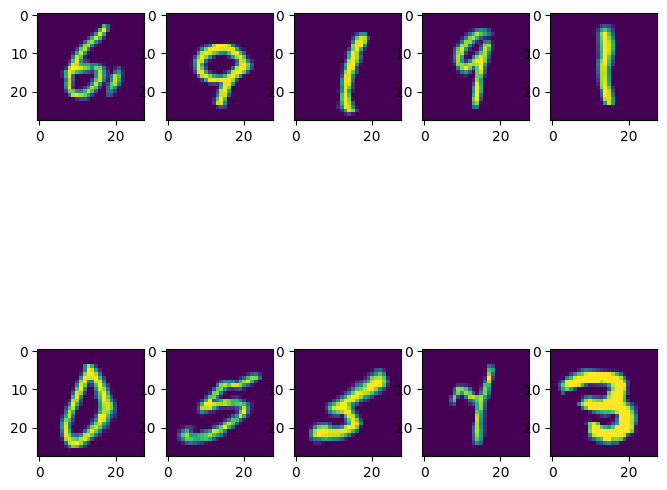

In [5]:
elastic = T.ElasticTransform()

fig=plt.figure(figsize=(8, 8))
for i in range(10):
    a = underlying_train_dset[i][0]
    a = elastic(a)[0]
    fig.add_subplot(2, 5, i+1)
    plt.imshow(a)

plt.show()

In [6]:
train_transform = T.Compose([
    T.ElasticTransform(),
    T.Normalize(0.1306, 0.3081)
])

valid_test_transform = T.Normalize(0.1306, 0.3081)

train_dset = MyDataset(underlying_train_dset, train_transform)
valid_dset = MyDataset(underlying_valid_dset, valid_test_transform)
test_dset = MyDataset(underlying_test_dset, valid_test_transform)

We now write our model, I'll go for a CNN with the highest number of tricks I can muster-

In [7]:
class Classifier(nn.Module):
    def __init__(self, conv_layers = [(16, 3, 1, 2), (16, 3, 1, 2), (16, 3, 1, None)], fin_dec=(2,2), linear_layers=[(128, .5), (128, .5)], classes=10):

        assert len(conv_layers) > 0
        assert len(linear_layers) > 0

        super().__init__()

        prev_dims = 1
        modules = []

        for i, (dims, k_size, stride, max_pool) in enumerate(conv_layers):
            
            conv = nn.Conv2d(prev_dims, dims, k_size, stride)

            nn.init.kaiming_normal_(conv.weight, a=.1, mode="fan_out", nonlinearity="leaky_relu")
            nn.init.constant_(conv.bias, 0)

            bn = nn.BatchNorm2d(dims)

            nn.init.constant_(bn.weight, 1)
            nn.init.constant_(bn.bias, 0)

            if max_pool is None or i >= len(conv_layers) - 1:
                pool = nn.Identity()
            else:
                pool = nn.MaxPool2d(max_pool)

            modules.append(conv)
            modules.append(nn.LeakyReLU(.1, True))
            modules.append(bn)
            modules.append(pool)

            prev_dims = dims
        
        modules.append(nn.AdaptiveMaxPool2d(fin_dec))
        modules.append(nn.Flatten())

        for v in fin_dec:
            prev_dims *= v

        for dims, p in linear_layers:
            
            ll = nn.Linear(prev_dims, dims)

            nn.init.kaiming_normal_(ll.weight, a=.1, mode="fan_out", nonlinearity="leaky_relu")
            nn.init.constant_(ll.bias, 0)

            bn = nn.BatchNorm1d(dims)

            nn.init.constant_(bn.weight, 1)
            nn.init.constant_(bn.bias, 0)

            modules.append(ll)
            modules.append(nn.LeakyReLU(.1, True))
            modules.append(bn)
            modules.append(nn.Dropout(p, True))

            prev_dims = dims

        ll = nn.Linear(prev_dims, classes)
        nn.init.kaiming_normal_(ll.weight, mode="fan_out", nonlinearity="linear")
        nn.init.constant_(ll.bias, 0)

        modules.append(ll)

        self.pred = nn.Sequential(*modules)

    def forward(self, x):
        return self.pred(x)
    
# Test
model = Classifier()
print(sum([p.numel() for p in model.parameters()]))

fake_in = torch.randn((32, 1, 28, 28))
fake_out = model(fake_in)
print(fake_out.shape)

del model
del fake_in
del fake_out

31530
torch.Size([32, 10])


Now that we've defined our model, let's define a small training loop:

In [8]:
def train(lr, wd, batch_size, epochs, train_dset=train_dset, valid_dset=valid_dset):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    torch.random.manual_seed(42)
    train = DataLoader(train_dset, batch_size, shuffle=True)
    valid = DataLoader(valid_dset, batch_size, shuffle=False)

    model = Classifier().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=.1, patience=3, threshold=.2, min_lr=1e-6)

    criterion = nn.CrossEntropyLoss(reduction="none")

    pbar = tqdm.tqdm()

    tot_train = len(train_dset)
    train_accus = []
    valid_accus = []

    best_accu = 0

    for epoch in range(epochs):
        losses = []
        accus = []

        model.train()

        pbar.set_description_str(f"Train {epoch + 1:02d}", refresh=False)
        pbar.reset(tot_train)
        
        for img, target in train:
            img = img.to(device)
            target = target.to(device)

            pred = model(img)

            loss = criterion(pred, target)
            loss.mean().backward()

            optimizer.step()
            optimizer.zero_grad()

            accu = (pred.argmax(-1) == target).float()

            losses.extend(loss.detach().cpu().tolist())
            accus.extend(accu.detach().cpu().tolist())

            if len(losses) >= tot_train * .1:
                mean_loss = torch.tensor(losses).mean().item()
                mean_accu = torch.tensor(accus).mean().item()
                pbar.set_postfix_str(f"loss={mean_loss:.3f}, accu={mean_accu:.3f}", refresh=False)
                losses.clear()
                accus.clear()
                train_accus.append(mean_accu)

            pbar.update(img.shape[0])
        
        model.eval()

        with torch.no_grad():
            losses = []
            accus = []

            for img, target in valid:
                img = img.to(device)
                target = target.to(device)

                pred = model(img)

                loss = criterion(pred, target)

                accu = (pred.argmax(-1) == target).float()

                losses.extend(loss.cpu().tolist())
                accus.extend(accu.cpu().tolist())

            mean_loss = torch.tensor(losses).mean().item()
            mean_accu = torch.tensor(accus).mean().item()
            print(f"Valid {epoch +1:02d}: loss={mean_loss:.3f}, accu={mean_accu:.3f}")

            valid_accus.append(mean_accu)
            scheduler.step(mean_accu)

            if best_accu < mean_accu:
                best_accu = mean_accu
    
    return model, train_accus, valid_accus, best_accu


In [9]:
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
wds = [1e-3, 1e-4, 1e-5, 0]
results = dict()

for lr in lrs:
    for wd in wds:
        _, _, _, accu = train(lr, wd, 32, 1)
        results[(lr, wd)] = accu

# W\ bn
# Train 01: 100%|██████████| 54000/54000 [01:56<00:00, 463.44it/s, Valid 01: loss=0.351, accu=0.943]
# Train 01: 100%|██████████| 54000/54000 [01:59<00:00, 450.89it/s, Valid 01: loss=0.779, accu=0.920]
# Train 01: 100%|██████████| 54000/54000 [02:00<00:00, 447.74it/s, Valid 01: loss=0.232, accu=0.960]
# Train 01: 100%|██████████| 54000/54000 [01:52<00:00, 481.36it/s, Valid 01: loss=0.430, accu=0.956]
# Train 01: 100%|██████████| 54000/54000 [01:53<00:00, 475.70it/s, Valid 01: loss=0.077, accu=0.976]
# Train 01: 100%|██████████| 54000/54000 [01:55<00:00, 466.85it/s, Valid 01: loss=0.087, accu=0.973]
# Train 01: 100%|██████████| 54000/54000 [01:55<00:00, 466.24it/s, Valid 01: loss=0.102, accu=0.968]
# Train 01: 100%|██████████| 54000/54000 [01:50<00:00, 486.74it/s, Valid 01: loss=0.085, accu=0.973]
# Train 01: 100%|██████████| 54000/54000 [01:50<00:00, 487.55it/s, Valid 01: loss=0.126, accu=0.962]
# Train 01: 100%|██████████| 54000/54000 [01:51<00:00, 482.61it/s, Valid 01: loss=0.132, accu=0.962]
# Train 01: 100%|██████████| 54000/54000 [01:51<00:00, 483.76it/s, Valid 01: loss=0.125, accu=0.964]
# Train 01: 100%|██████████| 54000/54000 [01:51<00:00, 483.94it/s, Valid 01: loss=0.125, accu=0.964]
# Train 01: 100%|██████████| 54000/54000 [01:51<00:00, 483.44it/s, Valid 01: loss=0.631, accu=0.824]
# Train 01: 100%|██████████| 54000/54000 [01:52<00:00, 482.03it/s, Valid 01: loss=0.625, accu=0.826]
# Train 01: 100%|██████████| 54000/54000 [01:52<00:00, 482.00it/s, Valid 01: loss=0.625, accu=0.826]
# Train 01: 100%|██████████| 54000/54000 [01:51<00:00, 485.27it/s, Valid 01: loss=0.625, accu=0.826]

Train 01: 100%|██████████| 54000/54000 [02:04<00:00, 432.91it/s, loss=1.309, accu=0.812]


Valid 01: loss=0.401, accu=0.934


Train 01: 100%|██████████| 54000/54000 [02:35<00:00, 346.35it/s, loss=1.320, accu=0.820]


Valid 01: loss=0.394, accu=0.943


Train 01: 100%|██████████| 54000/54000 [02:35<00:00, 346.97it/s, loss=1.001, accu=0.837]


Valid 01: loss=0.528, accu=0.936


Train 01: 100%|██████████| 54000/54000 [02:26<00:00, 368.66it/s, loss=1.738, accu=0.800]


Valid 01: loss=0.344, accu=0.956


Train 01: 100%|██████████| 54000/54000 [02:11<00:00, 411.90it/s, loss=0.251, accu=0.922]


Valid 01: loss=0.095, accu=0.970


Train 01: 100%|██████████| 54000/54000 [02:10<00:00, 415.01it/s, loss=0.245, accu=0.930]


Valid 01: loss=0.080, accu=0.979


Train 01: 100%|██████████| 54000/54000 [02:08<00:00, 421.00it/s, loss=0.250, accu=0.928]


Valid 01: loss=0.073, accu=0.979


Train 01: 100%|██████████| 54000/54000 [02:05<00:00, 428.61it/s, loss=0.249, accu=0.927]


Valid 01: loss=0.105, accu=0.969


Train 01: 100%|██████████| 54000/54000 [02:07<00:00, 423.47it/s, loss=0.529, accu=0.848]


Valid 01: loss=0.133, accu=0.959


Train 01: 100%|██████████| 54000/54000 [01:58<00:00, 454.87it/s, loss=0.531, accu=0.844]


Valid 01: loss=0.148, accu=0.953


Train 01: 100%|██████████| 54000/54000 [01:57<00:00, 457.88it/s, loss=0.528, accu=0.848]


Valid 01: loss=0.142, accu=0.957


Train 01: 100%|██████████| 54000/54000 [01:58<00:00, 454.06it/s, loss=0.528, accu=0.848]


Valid 01: loss=0.142, accu=0.957


Train 01: 100%|██████████| 54000/54000 [02:07<00:00, 425.04it/s, loss=2.365, accu=0.527]


Valid 01: loss=0.710, accu=0.787


Train 01: 100%|██████████| 54000/54000 [02:09<00:00, 417.80it/s, loss=2.362, accu=0.529]


Valid 01: loss=0.713, accu=0.791


Train 01: 100%|██████████| 54000/54000 [02:05<00:00, 431.22it/s, loss=2.362, accu=0.529]


Valid 01: loss=0.713, accu=0.791


Train 01: 100%|██████████| 54000/54000 [02:04<00:00, 433.01it/s, loss=2.362, accu=0.529]

Valid 01: loss=0.713, accu=0.791


In [10]:
print(results)

{(0.1, 0.001): 0.9338333606719971, (0.1, 0.0001): 0.9428333044052124, (0.1, 1e-05): 0.9358333349227905, (0.1, 0): 0.9558333158493042, (0.01, 0.001): 0.9704999923706055, (0.01, 0.0001): 0.9788333177566528, (0.01, 1e-05): 0.9793333411216736, (0.01, 0): 0.968666672706604, (0.001, 0.001): 0.9593333601951599, (0.001, 0.0001): 0.953499972820282, (0.001, 1e-05): 0.9574999809265137, (0.001, 0): 0.9574999809265137, (0.0001, 0.001): 0.7873333096504211, (0.0001, 0.0001): 0.7910000085830688, (0.0001, 1e-05): 0.7910000085830688, (0.0001, 0): 0.7910000085830688}
